<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37 - Part 2: Regression Benchmarking & Optimization</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

---
## Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Feature Selection](#2-feature-selection)
3. [Regression Benchmarking](#3-benchmarking)
4. [Model Optimization - Ensemble & Stacking](#4-optimization)
5. [Deployment - Final Submission](#5-deployment)


---

<a id='1-setup'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>1 | Setup & Data Loading</b></span>
    </h1>
</div>

### 1.1 Import Libraries

In [16]:
# Standard library
from itertools import combinations

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# Sklearn - Base
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

# Sklearn - Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression

# Sklearn - Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    ExtraTreesRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Sklearn - Metrics
from sklearn.metrics import (
    mean_absolute_error, 
    root_mean_squared_error, 
    mean_pinball_loss, 
    make_scorer,
)

# Custom utilities
import utils

import joblib
import lime
import lime.lime_tabular
# MLxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


# Plot style
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']

import random
from itertools import product
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from scipy.optimize import minimize
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge


# For reproducibility
random.seed(37)
np.random.seed(37)

### 1.2 Load Data

In [17]:
# Load the datasets (train, validation, test)
X_train_scaled = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val_scaled   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test_scaled  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set carID as index
X_train_scaled, X_val_scaled, X_test_scaled = [d.set_index('carID') for d in (X_train_scaled, X_val_scaled, X_test_scaled)]
y_train, y_val = [d.set_index('carID') for d in (y_train, y_val)]

print(f"Train: {X_train_scaled.shape[0]:,} rows, {X_train_scaled.shape[1]} features")
print(f"Val:   {X_val_scaled.shape[0]:,} rows")
print(f"Test:  {X_test_scaled.shape[0]:,} rows")

Train: 60,768 rows, 37 features
Val:   15,193 rows
Test:  32,567 rows


In [18]:
# Target arrays
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array   = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# Log transformation of target (reduces impact of outliers)
y_train_log = np.log1p(y_train_array)
y_val_log   = np.log1p(y_val_array)

# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

print(f"Train samples: {len(y_train_array):,}")
print(f"Val samples:   {len(y_val_array):,}")
print(f"Full samples:  {len(y_train_full_array):,}")

Train samples: 60,768
Val samples:   15,193
Full samples:  75,961


<a id='2-feature-selection'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2 | Feature Selection</b></span>
    </h1>
</div>

APAGAR: DIZER QUE JÁ TIRÁMOS YEAR, MODEL E PAINTQUALITY

### 2.2 Variance Threshold

In [19]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train_scaled)

# Get low variance columns and print them
low_variance = X_train_scaled.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train_scaled.columns.get_loc(col)]:.4f}")

# Drop low variance columns from train, val and test sets
X_train_scaled = X_train_scaled.drop(columns=low_variance, errors='ignore')
X_val_scaled = X_val_scaled.drop(columns=low_variance, errors='ignore')
X_test_scaled = X_test_scaled.drop(columns=low_variance, errors='ignore')

Number of features with variance closer to zero: 4
Features with variance closer to zero:
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other: 0.0022


### 2.3 Correlation Indices with price

In [20]:
# Correlação de cada feature com o target (price)
cor_with_target = pd.concat([
    X_train_scaled, 
    pd.Series(y_train_log, index=X_train_scaled.index, name='price')
], axis=1).corr(method='spearman')['price'].drop('price')

# Criar DataFrame ordenado por valor absoluto
cor_df = pd.DataFrame({
    'Feature': cor_with_target.index,
    'Correlation': cor_with_target.values,
    'Abs_Correlation': np.abs(cor_with_target.values)
}).sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)

# Mostrar
print("=== Correlation with Price (Spearman) ===")
display(cor_df)

# Destacar features com baixa correlação (|corr| < 0.1)
low_corr = cor_df[cor_df['Abs_Correlation'] < 0.1]
print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")
display(low_corr)

=== Correlation with Price (Spearman) ===


,Feature,Correlation,Abs_Correlation
0,model_mean_price,0.765409,0.765409
1,mpg_per_liter,-0.598963,0.598963
2,age,-0.595517,0.595517
3,age_squared,-0.595517,0.595517
4,brand_mean_price,0.579865,0.579865
5,transmission_manual,-0.579796,0.579796
6,age_mileage_interaction,-0.570180,0.570180
7,engineSize,0.562210,0.562210
8,brand_price_std,0.547267,0.547267
9,premium_brand_engine_size_interaction,0.546488,0.546488


\ Features with |corr| < 0.1 (11):


,Feature,Correlation,Abs_Correlation
22,fuelType_hybrid,0.073977,0.073977
23,mpg_is_missing,0.051705,0.051705
24,tax_is_missing,0.050216,0.050216
25,brand_segment_mid_range,-0.048382,0.048382
26,tax_per_engine,-0.037308,0.037308
27,brand_popularity,-0.015392,0.015392
28,engineSize_is_missing,-0.004615,0.004615
29,year_is_missing,0.003744,0.003744
30,transmission_unknown,0.002575,0.002575
31,fuelType_unknown,0.001427,0.001427


In [21]:
drop_features = ['mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 
                 'transmission_unknown', 'fuelType_unknown']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.4 Statistical Hypothesis Testing - ANOVA

In [22]:
from sklearn.feature_selection import f_regression

bin_cols = [c for c in X_train_scaled.columns if X_train_scaled[c].dropna().nunique() == 2]

X_train_cat = X_train_scaled.copy()
for c in bin_cols:
    X_train_cat[c] = X_train_scaled[c].astype('category')

alpha = 0.01

COLS = X_train_cat.columns.tolist()

# Prepare data - handle missing values
X_anova = X_train_cat[COLS].copy()
y_price = y_train_log.copy()  # It's already the price values

# Remove rows with NaN in either X or y
mask = ~(X_anova.isna().any(axis=1) | np.isnan(y_price))
X_anova_clean = X_anova[mask]
y_price_clean = y_price[mask]

# Run f_regression (sklearn's F-test for regression)
f_stats, p_values = f_regression(X_anova_clean, y_price_clean)

# Build results DataFrame
anova_results = []
for i, col in enumerate(COLS):
    decision = "predictive" if p_values[i] < alpha else "NOT predictive"
    anova_results.append({
        "Variable": col,
        "Test": "f_regression",
        "F_Stat": f_stats[i],
        "p_value": p_values[i],
        "Decision": decision
    })

df_anova = pd.DataFrame(anova_results).sort_values('p_value', na_position='last').reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(df_anova)
pd.reset_option('display.max_rows')

,Variable,Test,F_Stat,p_value,Decision
0,mileage,f_regression,23440.674454,0.000000e+00,predictive
1,tax,f_regression,7843.008120,0.000000e+00,predictive
2,mpg,f_regression,7512.339054,0.000000e+00,predictive
3,engineSize,f_regression,23766.720565,0.000000e+00,predictive
4,brand_price_std,f_regression,26033.787341,0.000000e+00,predictive
5,age_mileage_interaction,f_regression,34079.885139,0.000000e+00,predictive
6,miles_per_year,f_regression,5934.060893,0.000000e+00,predictive
7,age,f_regression,37785.238260,0.000000e+00,predictive
8,mpg_per_liter,f_regression,25084.478043,0.000000e+00,predictive
9,brand_mean_price,f_regression,28060.117306,0.000000e+00,predictive


In [23]:
drop_features = ['previousOwners']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.2 Calculate Feature Importance per Model

In [24]:
# Lasso Regularization (L1) 
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train_log)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train_scaled.columns)
lasso_importance = lasso_coefs.abs().sort_values(ascending=False)

# Ridge Regularization (L2) 
ridge_model = Ridge(alpha=1.0, random_state=37)
ridge_model.fit(X_train_scaled, y_train_log)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train_scaled.columns)
ridge_importance = ridge_coefs.abs().sort_values(ascending=False)

# ElasticNet Regularization (L1 + L2)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000)
elasticnet_model.fit(X_train_scaled, y_train_log)
elasticnet_coefs = pd.Series(elasticnet_model.coef_, index=X_train_scaled.columns)
elasticnet_importance = elasticnet_coefs.abs().sort_values(ascending=False)

# GB - Native Feature Importance
gb_base = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=37)
gb_base.fit(X_train_scaled, y_train_log)
gb_importance = pd.Series(gb_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# RF - Native Feature Importance
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train_log)
rf_importance = pd.Series(rf_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# ExtraTrees - Native Feature Importance
et_base = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
et_base.fit(X_train_scaled, y_train_log)
et_importance = pd.Series(et_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# Features eliminated by Lasso
lasso_eliminated = lasso_coefs[lasso_coefs == 0].index.tolist()
if lasso_eliminated:
    print(f"\n Features eliminated by Lasso: {lasso_eliminated}")
else:
    print(f"\n Lasso kept all features")

# Features eliminated by ElasticNet
elasticnet_eliminated = elasticnet_coefs[elasticnet_coefs == 0].index.tolist()
if elasticnet_eliminated:
    print(f" Features eliminated by ElasticNet: {elasticnet_eliminated}")
else:
    print(f" ElasticNet kept all features")

print("\n Feature importance calculated for all 7 methods")


 Features eliminated by Lasso: ['mileage', 'tax', 'mpg', 'engineSize', 'brand_price_std', 'brand_popularity', 'model_popularity', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'brand_mean_price', 'model_mean_price', 'is_new_car', 'is_old_car', 'high_mileage', 'low_mileage', 'transmission_manual', 'transmission_semi auto', 'fuelType_hybrid', 'fuelType_petrol', 'brand_segment_luxury', 'brand_segment_mid_range']
 Features eliminated by ElasticNet: ['mileage', 'tax', 'mpg', 'engineSize', 'brand_price_std', 'brand_popularity', 'model_popularity', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'brand_mean_price', 'model_mean_price', 'is_new_car', 'is_old_car', 'high_mileage', 'low_mileage', 'transmission_manual', 'transmission_semi auto', 'fuelType_hybrid', 'fuelType_petrol', 'brand_segment_luxury', 'brand_segment_mid_range']

 Fe

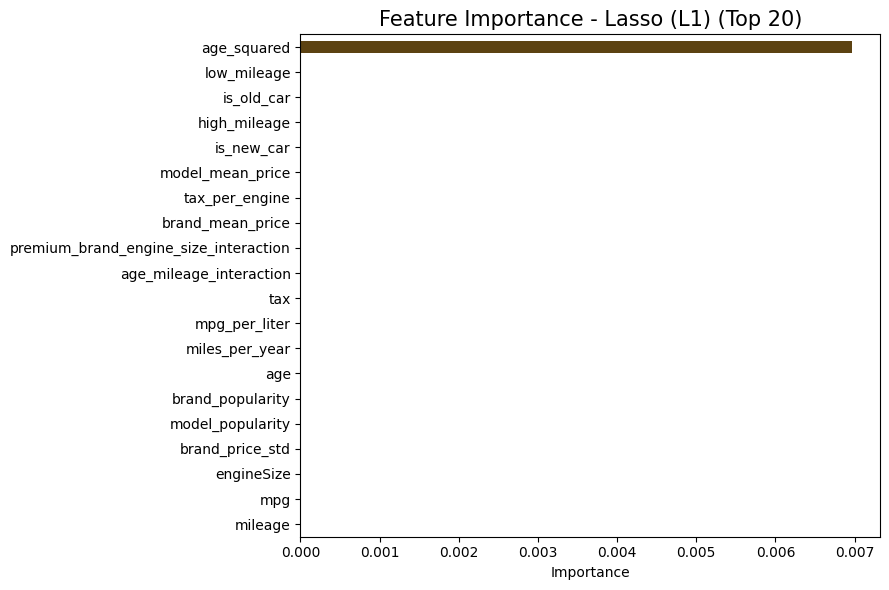


------------------------------------------------------------
MODEL: Lasso (L1)
Threshold: 0.0003
Selected: 1 features
Features: ['age_squared']
------------------------------------------------------------



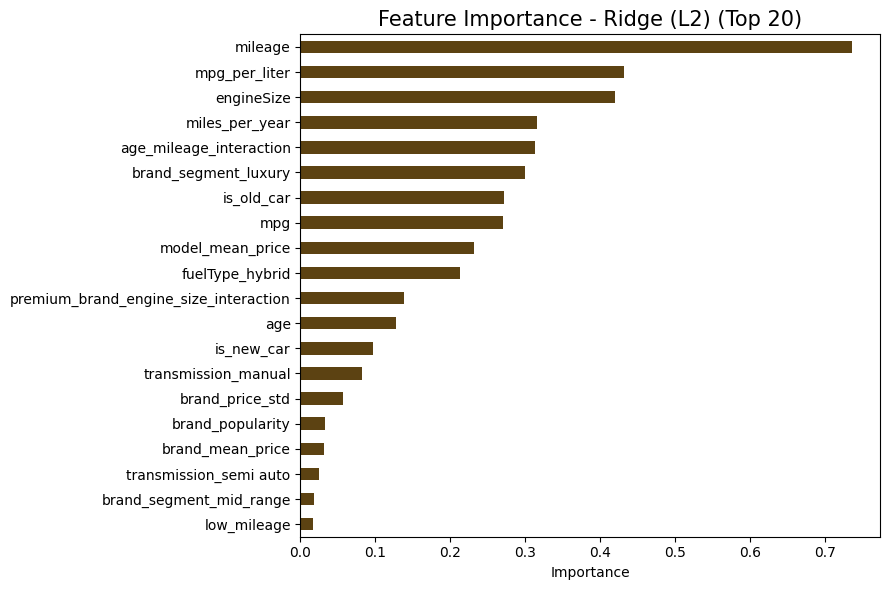


------------------------------------------------------------
MODEL: Ridge (L2)
Threshold: 0.1605
Selected: 10 features
Features: ['mileage', 'mpg', 'engineSize', 'miles_per_year', 'age_mileage_interaction', 'mpg_per_liter', 'model_mean_price', 'is_old_car', 'fuelType_hybrid', 'brand_segment_luxury']
------------------------------------------------------------



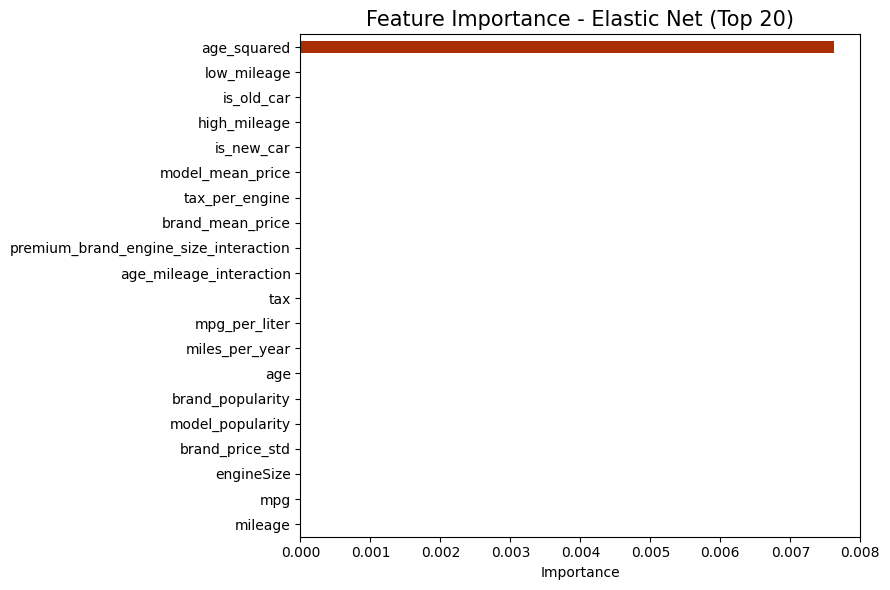


------------------------------------------------------------
MODEL: Elastic Net
Threshold: 0.0003
Selected: 1 features
Features: ['age_squared']
------------------------------------------------------------



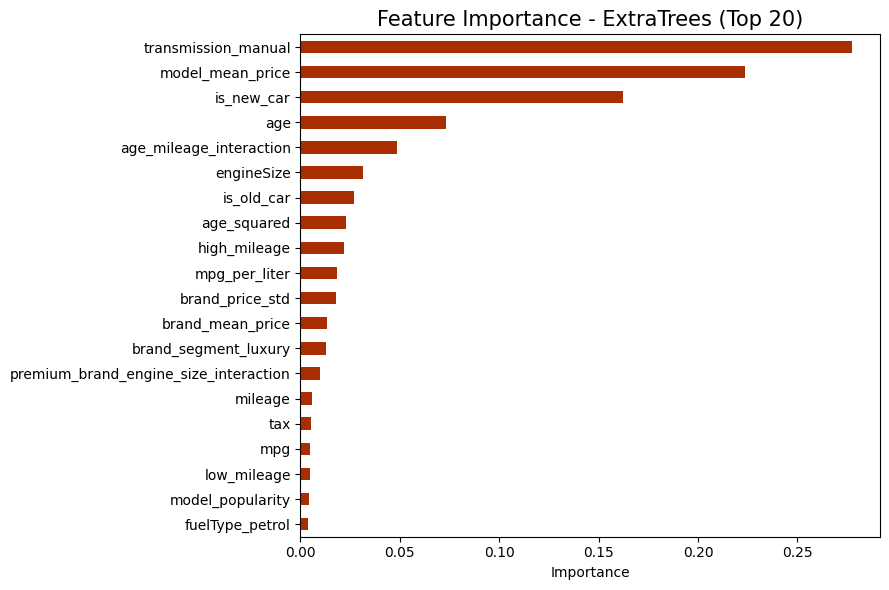


------------------------------------------------------------
MODEL: ExtraTrees
Threshold: 0.0385
Selected: 5 features
Features: ['transmission_manual', 'model_mean_price', 'is_new_car', 'age', 'age_mileage_interaction']
------------------------------------------------------------



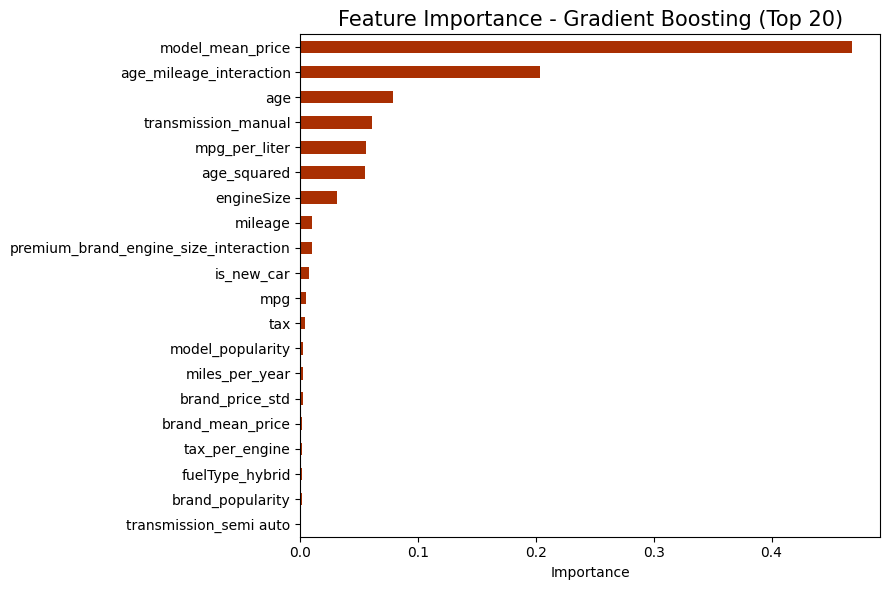


------------------------------------------------------------
MODEL: Gradient Boosting
Threshold: 0.0385
Selected: 6 features
Features: ['model_mean_price', 'age_mileage_interaction', 'age', 'transmission_manual', 'mpg_per_liter', 'age_squared']
------------------------------------------------------------



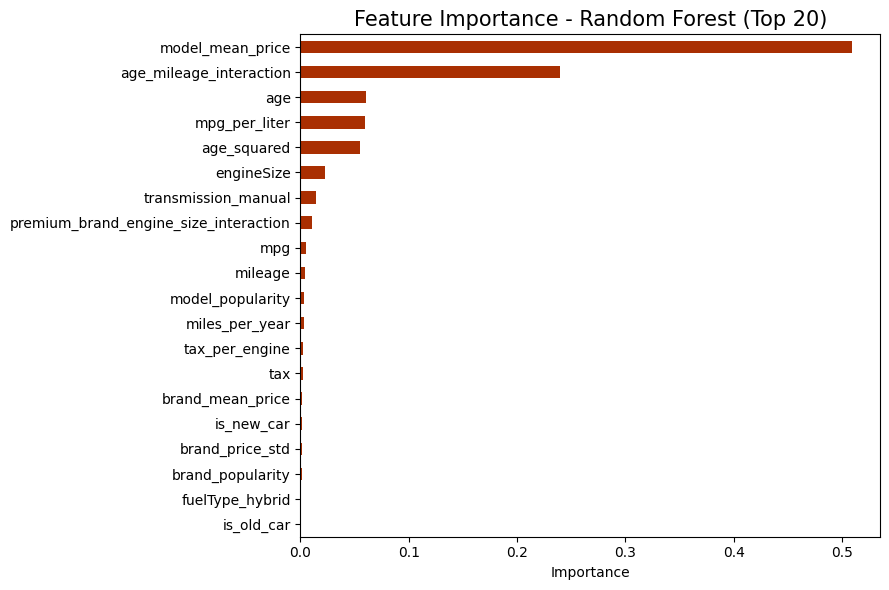


------------------------------------------------------------
MODEL: Random Forest
Threshold: 0.0385
Selected: 5 features
Features: ['model_mean_price', 'age_mileage_interaction', 'age', 'mpg_per_liter', 'age_squared']
------------------------------------------------------------



['model_mean_price',
 'age_mileage_interaction',
 'age',
 'mpg_per_liter',
 'age_squared']

In [25]:
# Plot feature importance
utils.plot_importance_unified(palette, abs(lasso_coefs), "Lasso (L1)", is_tree_model=False)
utils.print_selection_results(abs(lasso_coefs), "Lasso (L1)")

utils.plot_importance_unified(palette, abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 
utils.print_selection_results(abs(ridge_coefs), "Ridge (L2)")

utils.plot_importance_unified(palette, elasticnet_importance, "Elastic Net", is_tree_model=True)
utils.print_selection_results(elasticnet_importance, "Elastic Net")

utils.plot_importance_unified(palette, et_importance, "ExtraTrees", is_tree_model=True)
utils.print_selection_results(et_importance, "ExtraTrees")

utils.plot_importance_unified(palette, gb_importance, "Gradient Boosting", is_tree_model=True)
utils.print_selection_results(gb_importance, "Gradient Boosting")

utils.plot_importance_unified(palette, rf_importance, "Random Forest", is_tree_model=True)
utils.print_selection_results(rf_importance, "Random Forest")

### 2.3 Select Optimal Number of Features

We test different numbers of top features to find the optimal subset for each model.

In [26]:
# Create ranks for each model (1 = most important)
elasticnet_ranks = pd.Series(range(1, len(elasticnet_importance) + 1), index=elasticnet_importance.index)
et_ranks = pd.Series(range(1, len(et_importance) + 1), index=et_importance.index)
gb_ranks = pd.Series(range(1, len(gb_importance) + 1), index=gb_importance.index)
rf_ranks = pd.Series(range(1, len(rf_importance) + 1), index=rf_importance.index)

# Combine and sort
feature_ranks = (elasticnet_ranks + et_ranks + gb_ranks + rf_ranks).sort_values()

# Final sorted list
ranked_features = feature_ranks.index.tolist()
print(ranked_features)

# Model configurations
model_configs = {
    'ELASTICNET': lambda: ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000),
    'ET': lambda: ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1),
    'GB': lambda: GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.06, random_state=37),
    'RF': lambda: RandomForestRegressor(n_estimators=100, max_depth=15, random_state=37, n_jobs=-1),
    'KNN': lambda: KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)
}

# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': ranked_features,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}


feature_range = range(1, len(ranked_features) + 1)

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = ranked_features[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_log)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, np.expm1(model.predict(X_train_scaled[features])))
        val_mae = mean_absolute_error(y_val_array, np.expm1(model.predict(X_val_scaled[features])))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f}")


['age', 'age_mileage_interaction', 'age_squared', 'model_mean_price', 'engineSize', 'mpg_per_liter', 'transmission_manual', 'mileage', 'mpg', 'premium_brand_engine_size_interaction', 'is_new_car', 'brand_price_std', 'model_popularity', 'tax', 'miles_per_year', 'brand_mean_price', 'tax_per_engine', 'brand_popularity', 'is_old_car', 'high_mileage', 'brand_segment_luxury', 'fuelType_hybrid', 'fuelType_petrol', 'low_mileage', 'transmission_semi auto', 'brand_segment_mid_range']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 1 | ElasticNet: 6,810 | ExtraTrees: 5,500 | GB: 5,500 | RF: 5,500 | KNN: 5,759
n= 2 | ElasticNet: 6,810 | ExtraTrees: 5,401 | GB: 5,391 | RF: 5,406 | KNN: 5,770
n= 3 | ElasticNet: 6,250 | ExtraTrees: 5,401 | GB: 5,391 | RF: 5,406 | KNN: 5,795
n= 4 | ElasticNet: 6,250 | ExtraTrees: 2,377 | GB: 2,177 | RF: 2,181 | KNN: 2,229
n= 5 | ElasticNet: 6,250 | ExtraTrees: 1,960 | GB: 1,661 | RF: 1,627 | KNN: 1,709
n= 6 | ElasticNet: 6,250 | ExtraTrees: 1,871 | GB: 1,493 | RF: 1,417

Vamos focar-nos em escolher as variaveis com base nos dois melhores modelos

In [27]:
final_features = [#'age',
                   'age_squared', 
                  #'age_mileage_interaction', 
                   'model_mean_price', 
                   'engineSize', 
                   'mpg_per_liter', 
                   'transmission_manual',
                   'mileage', 
                   'mpg',
                   'premium_brand_engine_size_interaction', 
                   #'is_new_car', 
                   'brand_price_std', 
                   'model_popularity', 
                   'tax', 
                   #'miles_per_year', 
                   'brand_mean_price', 
                   'tax_per_engine', 
                   'brand_popularity', 
                   'is_old_car', 
                   #'high_mileage', 
                   'fuelType_hybrid', 
                   #'brand_segment_luxury', 
                   'fuelType_petrol', 
                   #'low_mileage', 
                   #'transmission_semi auto', 
                   'brand_segment_mid_range']

In [28]:
final_features_sorted_rf = (
    rf_importance
    .loc[final_features]
    .sort_values(ascending=False)
    .index
    .tolist()
)

print(final_features_sorted_rf)

feature_range = range(1, len(final_features)+1)

best_results ={}
# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': final_features_sorted_rf,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = final_features_sorted_rf[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_log)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, np.expm1(model.predict(X_train_scaled[features])))
        val_mae = mean_absolute_error(y_val_array, np.expm1(model.predict(X_val_scaled[features])))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

 # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f}")


['model_mean_price', 'mpg_per_liter', 'age_squared', 'engineSize', 'transmission_manual', 'premium_brand_engine_size_interaction', 'mpg', 'mileage', 'model_popularity', 'tax_per_engine', 'tax', 'brand_mean_price', 'brand_price_std', 'brand_popularity', 'fuelType_hybrid', 'is_old_car', 'brand_segment_mid_range', 'fuelType_petrol']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 1 | ElasticNet: 6,810 | ExtraTrees: 4,356 | GB: 4,351 | RF: 4,351 | KNN: 4,494
n= 2 | ElasticNet: 6,810 | ExtraTrees: 3,786 | GB: 2,967 | RF: 2,471 | KNN: 2,434
n= 3 | ElasticNet: 6,250 | ExtraTrees: 2,440 | GB: 1,743 | RF: 1,573 | KNN: 1,595
n= 4 | ElasticNet: 6,250 | ExtraTrees: 2,274 | GB: 1,661 | RF: 1,525 | KNN: 1,547
n= 5 | ElasticNet: 6,250 | ExtraTrees: 2,194 | GB: 1,615 | RF: 1,494 | KNN: 1,520
n= 6 | ElasticNet: 6,250 | ExtraTrees: 2,156 | GB: 1,615 | RF: 1,487 | KNN: 1,518
n= 7 | ElasticNet: 6,250 | ExtraTrees: 2,123 | GB: 1,599 | RF: 1,477 | KNN: 1,524
n= 8 | ElasticNet: 6,250 | ExtraTrees: 1,850 | GB: 

Lets use 14


Plotting visuals...



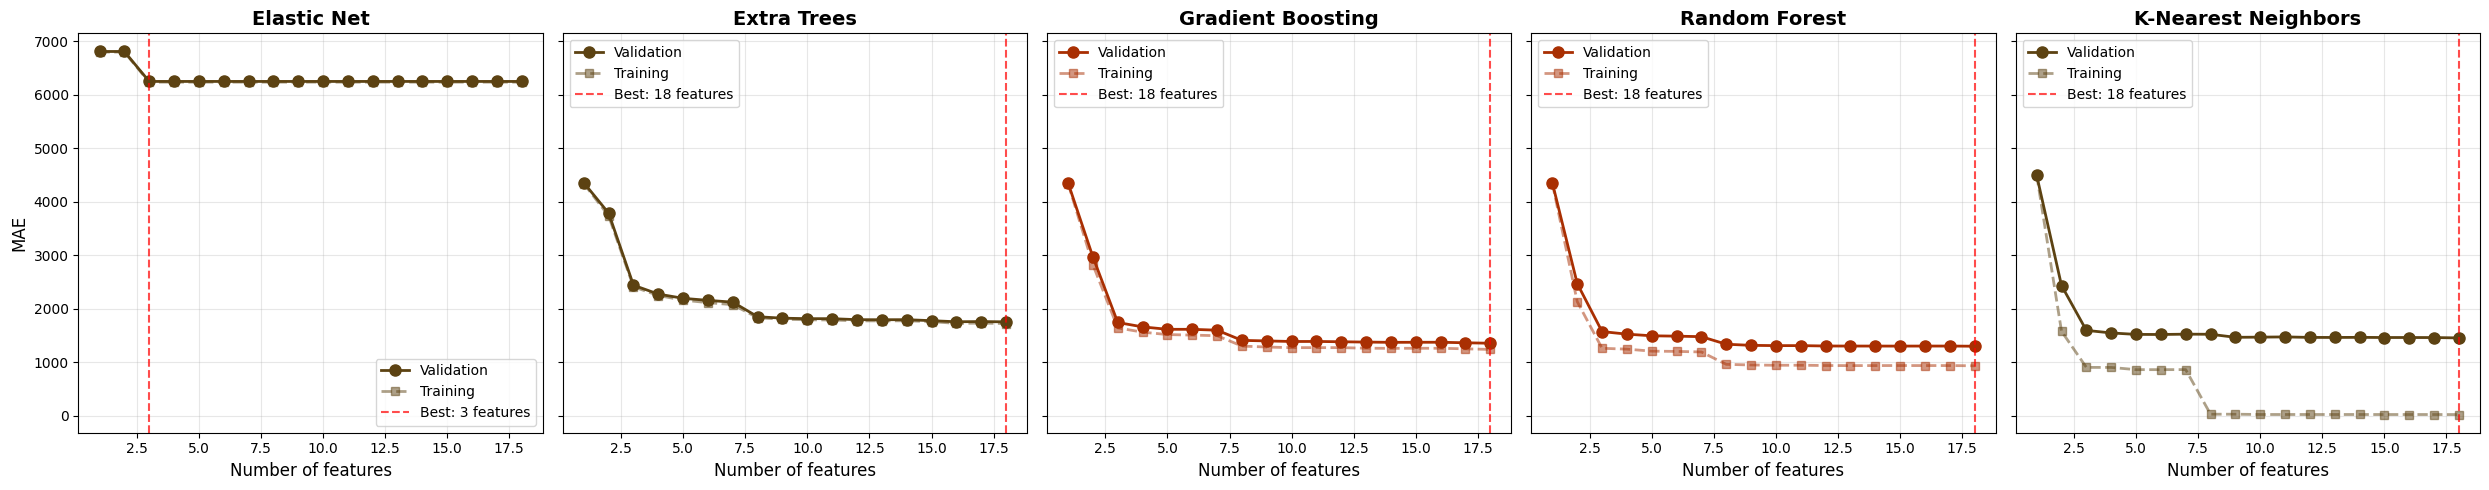

In [29]:
print("\nPlotting visuals...\n")

# X-axis: number of features tested
n_values = list(feature_range)

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)

# (chave_no_dict, título_para_o_gráfico, cor_base_index_palette)
plots_config = [
    ("ELASTICNET", "Elastic Net", 0),
    ("ET",         "Extra Trees", 0),
    ("GB",         "Gradient Boosting", 1),
    ("RF",         "Random Forest", 1),
    ("KNN",        "K-Nearest Neighbors", 0),
]

for ax, (model_key, title, color_idx) in zip(axes, plots_config):
    train_history = best_results[model_key]["train_history"]
    val_history = best_results[model_key]["val_history"]
    best_n = best_results[model_key]["best_n"]

    # Validation
    ax.plot(
        n_values, val_history,
        marker="o", linewidth=2, markersize=8,
        color=palette[color_idx], label="Validation"
    )

    # Training
    ax.plot(
        n_values, train_history,
        marker="s", linewidth=2, markersize=6,
        color=palette[color_idx], alpha=0.5,
        linestyle="--", label="Training"
    )

    # Best vertical line
    ax.axvline(
        best_n, color="red", linestyle="--", alpha=0.7,
        label=f"Best: {int(best_n)} features"
    )

    ax.set_xlabel("Number of features", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Shared Y label (only once because sharey=True)
axes[0].set_ylabel("MAE", fontsize=12)

plt.tight_layout()
plt.show()


In [30]:
print(final_features_sorted_rf)

['model_mean_price', 'mpg_per_liter', 'age_squared', 'engineSize', 'transmission_manual', 'premium_brand_engine_size_interaction', 'mpg', 'mileage', 'model_popularity', 'tax_per_engine', 'tax', 'brand_mean_price', 'brand_price_std', 'brand_popularity', 'fuelType_hybrid', 'is_old_car', 'brand_segment_mid_range', 'fuelType_petrol']


In [31]:
selected_features = ['model_mean_price', 'model_popularity', 
                     'brand_mean_price','premium_brand_engine_size_interaction', 
                     'engineSize', 'mpg', 'mileage', 'tax'
                     'mpg_per_liter', 'age_squared', 'tax_per_engine',
                     'transmission_manual', 'fuelType_hybrid', 'fuelType_petrol']

<a id='3-benchmarking'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

We use a **holdout validation strategy** (80/20 split) to evaluate models. The primary metric is **Mean Absolute Error (MAE)** as it directly represents the average prediction error in pounds.

Estratégia de Holdout: O código usa a divisão Train / Validation (Holdout Validation). Os modelos são treinados em $\mathbf{X_{\text{train\_scaled}}}$ e avaliados em $\mathbf{X_{\text{val\_scaled}}}$.Otimização de Hiperparâmetros (Grid Search Manual):O loop for model_name, config in models_and_grids.items(): executa um Grid Search manual (itera sobre todas as combinações em config['params']).Métrica de Otimização: O critério de otimização é o Val MAE (best_val_mae = float('inf')). O modelo que minimiza o Erro Absoluto Médio no conjunto de Validação é o "melhor".

 A função evaluate_model garante que a previsão (model.predict(X)) é feita na escala $\mathbf{\log(price)}$ e é transformada inversamente (np.expm1) para calcular as métricas na escala original (£). Isto atende ao seu requisito de interpretabilidade.
 Você quer usar $\mathbf{\alpha=0.3}$ (ou similar, e.g., $\mathbf{0.35}$) para refletir a aversão ao risco de sobrestimar o preço.

APAGAR

### 3.1 Evaluation Function

<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

APAGAR:
EXPLICAR O SOTRYTELLING ONDE EXPLICO A ESCOLHA DAS MÉTRICAS E ESCOLHA DE PARÂMETROS

NOFREE LUNCH THEOREM

In [32]:
selected_features =  ['model_mean_price', 'model_popularity', 
                     'brand_mean_price','premium_brand_engine_size_interaction', 
                     'engineSize', 'mpg', 'mileage', 'tax',
                     'mpg_per_liter', 'age_squared', 'tax_per_engine',
                     'transmission_manual', 'fuelType_hybrid', 'fuelType_petrol']

In [33]:
def evaluate_model(model, X_train, y_train_original, X_val, y_val_original):
    """
    Evaluate the model and return various metrics on original scale (£)

    Parameters
    ----------
    model : sklearn estimator
        The trained model to evaluate.
    X_train : pd.DataFrame
        Training features.
    y_train_original : np.array
        Original training target values (not log-transformed).
    X_val : pd.DataFrame
        Validation features.
    y_val_original : np.array
        Original validation target values (not log-transformed).

    Returns
    -------
    dict
        A dictionary containing MAE, RMSE, and Pinball Loss for both training and validation sets.    
    """

    # Predict on log scale
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)
    
    # Transform predictions back to original scale (£) in order to calculate interpretable metrics
    y_train_pred = np.expm1(y_train_pred_log)
    y_val_pred = np.expm1(y_val_pred_log)
    
    scores = {
        'Train MAE': mean_absolute_error(y_train_original, y_train_pred),
        'Val MAE': mean_absolute_error(y_val_original, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train_original, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val_original, y_val_pred),
        'Train Pinball (α=0.3)': mean_pinball_loss(y_train_original, y_train_pred, alpha=0.3),
        'Val Pinball (α=0.3)': mean_pinball_loss(y_val_original, y_val_pred, alpha=0.3)
    }
    return scores

- ter uma decision tree faz com que o meu modelo seja bias, e para poder generalizar melhor é bom introduzir randomness
Queremos ter vários modelos treino (in parallel) a trabalhar em diferentes partes do dataset (sampling with replacement) que nos average

We know that Decision Trees are usually not strong standalone models (high error, high variance, low stability, and high sensitivity to noise),
     so we will not use them directly. But this is exactly where ensemble learning methods (bagging, boosting,...) come in.
claro que podíamos usar utros modelos mas já que foram criados para estes deixamos.

definir o número de estimators (quantos modelos a treinar em paralelo) como queremos evitar overfitting ou ter mais variance queremos mais
boo


ATENÇÃO NÃO CHAMAR DE ENSEMBLE AVERAGING!!!!!!
APAGAR

VAMOS USAR DOS MODELOS DE BAGGING ESPECIFICOS: RANDOM FOREST E EXTRA TREES
Bagging helps when the model is more complex


    # ----------------------------------------------------------------------------------
    # 3. Extra Trees Regressor (Bagging Rápido e de Baixa Variância)
    # ----------------------------------------------------------------------------------
    # doesn't use bootstrap
    #Em vez de procurar o melhor split entre as features (RandoForest),O ExtraTrees testa thresholds aleatórios
    # E escolhe o melhor entre esses thresholds aleatórios
    # #isto reduz o tempo
    # aumenta diversidade entre as árvores
    # reduz overfitting
    # Para cada feature candidata,Escolhe um threshold aleatório. E usa esse threshold diretamente
    # Não procura o melhor split → isto aumenta a aleatoriedade.
    # APAGAR
#✔️ Mais rápido: não testa todos os thresholds
#✔️ Menos overfitting: árvores ficam mais “suaves”
#✔️ Mais diversidade entre árvores no ensemble

#estimator that allows for more randomness like DT APAGAR rf


O objetivo do tuning do Random Forest é encontrar o equilíbrio entre reduzir a variância (adicionando mais árvores) e manter a diversidade entre elas (controlando as features e a profundidade).


ExtraTreeRegressor é uma Decision Tree extremamente aleatória, em que os splits são escolhidos com thresholds aleatórios em vez de serem otimizados.
Isso torna as árvores mais rápidas, menos propensas a overfitting e muito mais eficazes quando usadas em ensembles como ExtraTrees ou Bagging.
Escolha do threshold (split) é ALEATÓRIA

ExtraTrees já traz tanta aleatoridade nos splits que adicionar bootstrap (amostragem com reposição) não traz benefícios significativos.

In [34]:
# Model configurations and hyperparameter grids (for a manual Random Search)
models_and_grids = {
    "Elastic Net": {
        "model": ElasticNet(random_state=37, max_iter=2000, tol=0.001),
        "params": {
             'alpha': [0.01, 1, 10], # regularization strength
             'l1_ratio': [0.75, 0.5, 0.25] #focus more on l1_ratio or not
        } 
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(n_jobs=-1, algorithm='ball_tree'), #ball_tree to speed up
        "params": {
            'n_neighbors': [100, 500], # number of neighbors
            'weights': ['distance', 'uniform'], #weight of each neighbor
            'p': [1, 2],  #distance metric:  distância de Manhattan costuma ser mais robusta em espaços de alta dimensão.APAGAR
        }
    },
    "MLPRegressor": {
        "model": MLPRegressor(random_state=37, max_iter=1500, early_stopping=True,tol= 0.001, n_iter_no_change=15),
        "params": {
            "hidden_layer_sizes": [(15,10,7,3), (34, 15, 5)], #following more or less the rule of thumbs we learned in class, this should be ok
            #it a common practice to start with layers that funnel down and also multiple layers (depth) are generally better than a single very wide layer
            "activation": ["relu", "tanh"], #relu: computationally efficient, helps avoid vanishing gradient problem; tanh: zero-centered, which can help in learning
            "alpha": [0.01, 0.001], #to prevent overfitting
            "batch_size": [128, 256], # a little bigger batches to speed up
        
            "solver": ["adam", "sgd"], #adam: efficient for large datasets; lbfgs: can converge faster for smaller datasets
            "learning_rate_init": [0.001, 0.01], #initial learning rate shouldn't be too high to avoid overshooting minima or too low to avoid slow convergence 

            #ADAM specific parameters
            "beta_1": [0.9],
            "beta_2": [0.999],

            #SGD specific parameters
            "learning_rate": ['adaptive'], 
            "momentum": [0.9], 
            "nesterovs_momentum": [True]
        }
    },
    # We know that Decision Trees are usually not strong standalone models (high error, high variance, low stability, and high sensitivity to noise),
    # so we will not use them directly. But this is exactly where ensemble learning methods (bagging, boosting,...) come in.

    #estimator that allows for more randomness like DT APAGAR
    #Random Forest of Random Trees
    "Extra Tree": {
        "model": ExtraTreesRegressor(random_state=37, n_jobs=-1, bootstrap=False), # the split is already random, we don't need bootstrap samples
        "params": {
            'n_estimators': [250, 500], #number of models trained in parallel, we choose high numbers so hopefully it won't overfit and make the result more trustworthy
            'max_depth': [15, 20],
            'min_samples_leaf': [15, 30], # to make sure each leaf has enough samples (not too specific)
            'max_features': ['sqrt', 0.8]
        }
    },
    #Bagging ensemble method that uses bootstrap samples and bootstrap feature subsets based on Decision Trees: Random Forest
    "RandomForest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1, max_samples=0.7),
        "params": {
            'n_estimators': [300, 500],
            'max_features': ['sqrt', 1],
            'max_depth': [15, 20],
            'min_samples_split': [90,120],
            'min_samples_leaf': [15,30],
            #min_impurity_decrease APAGAR: SE FOR NECESSÁRIO + PRUNNUNG
        }
    },
    # Boosting
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=37, loss='absolute_error'),
        "params": {
            'learning_rate': [0.01, 0.05], # low for stability
            'max_depth': [5, 8], # low depth for weak learners
            'n_estimators': [500, 1000], #to compensate for low learning rate
            'subsample': [0.75, 0.85], # subsampling for regularization (anti-overfitting)
            'max_features': ['sqrt', 0.8],
            'min_samples_leaf': [15, 30]
        }
    },
}

print("Selection Criterion: Minimization of VAL MAE (scale £)")
print("Risk Metric: VAL PINBALL (alpha=0.3)")

#O loop itera sobre cada modelo no dicionário models_and_grids (ElasticNet, KNN, ET, RF, GB).
#Seleção de Features: Cria os subsets de features ($\mathbf{X_{\text{tr}}}$ e $\mathbf{X_{\text{vl}}}$) 
#usando a lista fixa selected_features que você definiu (resultado da sua Feature Selection anterior).
#Combinações: param_combinations gera todas as combinações possíveis de hiperparâmetros definidas no Grid de cada modelo
for model_name, config in models_and_grids.items():

#O modelo é clonado, os parâmetros são aplicados e ele é treinado usando o Target log-transformado
    #A função evaluate_model é chamada. Ela prevê na escala $\mathbf{\log}$ e converte os resultados de volta para a escala £ (np.expm1), para que as métricas (MAE, Pinball) sejam interpretáveis.
    #O if scores['Val MAE'] < best_val_mae: garante que o modelo com o menor erro absoluto médio (£) no conjunto de Validação é o escolhido como o "melhor" modelo dessa família.
    for values in tested_params:


ESTAMOS A DAR AS MESMAS CHANCES DE MELHORIA A CADA MODELO USANDO OS PARÂMETROS QUE ACREDITAMOS SEREM MAIS RELEVANTES

MAE_train / MAE_val < 0.75
Independe da escala do target.
Comparável entre problemas, modelos e datasets.Permite definir thresholds universais.
Isto já indica que o modelo está a “decorar” padrões do treino e a falhar no validation.


1. Eliminação Inicial (Critério Principal: Erro de Generalização)
O Val MAE (Mean Absolute Error na validação) é o seu critério principal, pois é robusto, fácil de interpretar (erro médio na escala original) e é o que você usou para selecionar a melhor configuração dentro de cada algoritmo.
Ação: Descarte os modelos que apresentarem o maior (pior) Val MAE.
Objetivo: Eliminar os algoritmos que intrinsecamente têm a pior capacidade preditiva no seu problema.
Regra: Eliminar o modelo com o pior Val MAE e o modelo com o segundo pior Val MAE.

2. Desempate Intermédio (Critério Secundário: Erro Quadrático)
O Val RMSE (Root Mean Squared Error) penaliza erros grandes de forma muito mais severa do que o MAE (devido ao quadrado). É uma métrica crucial se você não quer errar muito em poucos casos.
Ação: Dos modelos restantes, elimine aquele que tiver o pior Val RMSE.
Objetivo: Garantir que o modelo escolhido seja robusto contra grandes erros (que são comuns em datasets de preços).

3. Desempate Final (Critério de Negócio: Quantile/Pinball)
O Val Pinball (α=0.3) é uma métrica assimétrica que penaliza mais os erros de subestimação (prever um preço muito baixo quando o preço real é alto). Se for um problema de previsão de preços, isso pode ser um requisito de negócio.
Ação: Dos dois modelos restantes (após a eliminação baseada no RMSE), selecione o que tiver o melhor (menor) Val Pinball (α=0.3) para ser um dos finalistas.
Objetivo: Priorizar o modelo que melhor se alinha com o requisito específico de negócio (neste caso, subestimar menos o preço).

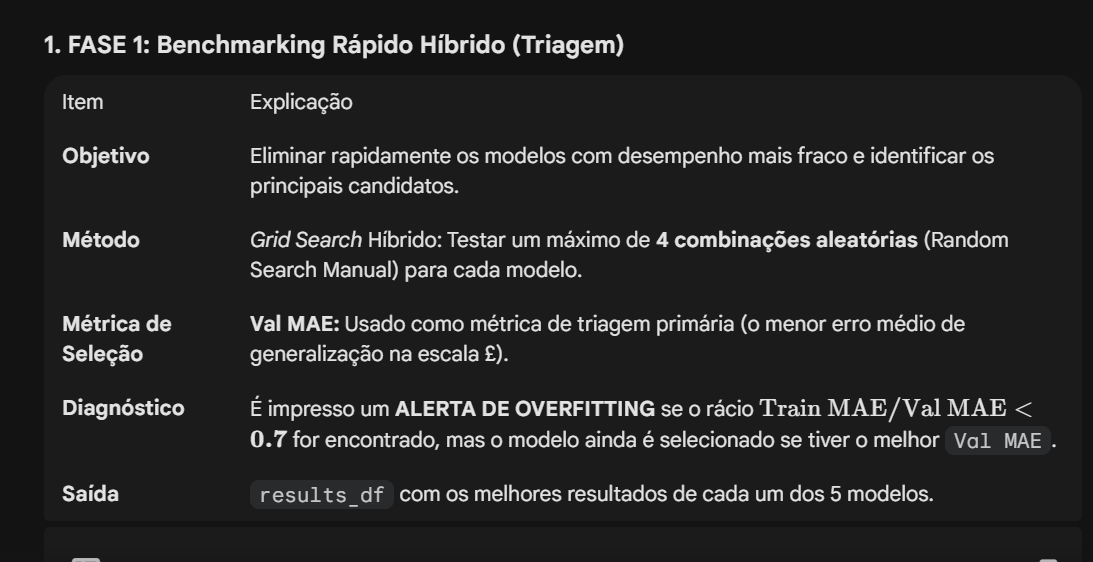

In [35]:
# easier names
y_train_original_for_eval = y_train_array 
y_val_original_for_eval = y_val_array
y_train_log_for_fit = y_train_log

########################################################
# 1: hybrid benchmarking (MANUAL RANDOM SEARCH)        #
########################################################
results_list = []

print("PHASE 1: Initial benchmarking with Manual Random Search")
print("="*80)

# Loop through each model and its hyperparameter grid
for model_name, config in models_and_grids.items():
    print(f"\n---> Optimizing {model_name}")
    
    X_tr = X_train_scaled[selected_features]
    X_vl = X_val_scaled[selected_features]
    
    # Generate all possible parameter combinations
    param_combinations = list(product(*config['params'].values()))
    param_keys = list(config['params'].keys())

    # Select at most 4 random combinations to test
    if len(param_combinations) > 4:
        tested_params = random.sample(param_combinations, 4)
        print(f"Testing 4 random combinations out of {len(param_combinations)}:\n")
    else:
        tested_params = param_combinations
        print(f"Testing all {len(param_combinations)} combinations:\n")

    # track the best model and its metrics
    best_val_mae = float('inf')
    best_result = None

    # Loop through the parameters
    for values in tested_params:
        params = dict(zip(param_keys, values))
        model = clone(config['model'])
        model.set_params(**params)
        model.fit(X_tr, y_train_log_for_fit) # fit on log-price
        
        scores = evaluate_model(model, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval) #gets scores in original scale (£)

        # the model with the lowest Val MAE is considered the best model for that family algorithm
        if scores['Val MAE'] < best_val_mae:
            best_val_mae = scores['Val MAE']
            best_result = {
                'Model': model_name,
                'Best Params': str(params),
                **scores,
                }
            
            # Check for overfitting
            overfit_ratio = scores['Train MAE'] / scores['Val MAE']
            if overfit_ratio < 0.75:
                print(f"    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: {overfit_ratio:.2f} !!!")
            print(f"  New best: {params} | VAL MAE:{scores['Val MAE']:,.2f} | Pinball(0.3):{scores['Val Pinball (α=0.3)']:.2f} | Val RMSE:{scores['Val RMSE']:.2f} ")

    # only adds the best VAL MAE result of each model to the phase 1 results list
    if best_result:
        results_list.append(best_result)

   
# Final results phase 1 DataFrame
results_df = pd.DataFrame(results_list).sort_values('Val MAE')
print("\n" + "="*80)
print("Final benchmarking results per model (phase 1):")
display(results_df[['Model','Train MAE', 'Val MAE','Train Pinball (α=0.3)', 'Val Pinball (α=0.3)','Train RMSE', 'Val RMSE', 'Best Params']])

# Get the best parameters from phase 1 for use in phase 2
best_params_phase1 = {}
for model_name in results_df['Model'].unique():
    params_str = results_df[results_df['Model'] == model_name]['Best Params'].values[0]
    best_params_phase1[model_name] = eval(params_str)

print("\nOptimized Parameters from Phase 1:")
for name, params in best_params_phase1.items():
    print(f" - {name}: {params}")


PHASE 1: Initial benchmarking with Manual Random Search

---> Optimizing Elastic Net
Testing 4 random combinations out of 9:

  New best: {'alpha': 0.01, 'l1_ratio': 0.5} | VAL MAE:2,323.87 | Pinball(0.3):1082.16 | Val RMSE:3972.12 
  New best: {'alpha': 0.01, 'l1_ratio': 0.25} | VAL MAE:2,302.58 | Pinball(0.3):1077.16 | Val RMSE:3925.56 

---> Optimizing KNeighbors
Testing 4 random combinations out of 8:

  New best: {'n_neighbors': 500, 'weights': 'uniform', 'p': 2} | VAL MAE:2,358.15 | Pinball(0.3):1028.45 | Val RMSE:4204.29 
    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: 0.01 !!!
  New best: {'n_neighbors': 500, 'weights': 'distance', 'p': 1} | VAL MAE:1,875.79 | Pinball(0.3):835.99 | Val RMSE:3571.63 
    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: 0.01 !!!
  New best: {'n_neighbors': 100, 'weights': 'distance', 'p': 1} | VAL MAE:1,578.28 | Pinball(0.3):735.59 | Val RMSE:2974.85 

---> Optimizing MLPRegressor
Testing 4 random combinations out of 64:

  New best: {'hidde

,Model,Train MAE,Val MAE,Train Pinball (α=0.3),Val Pinball (α=0.3),Train RMSE,Val RMSE,Best Params
5,GradientBoosting,1170.874921,1309.125574,553.328341,619.084814,2211.675248,2312.903450,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est..."
3,Extra Tree,1431.959816,1508.462390,662.668292,701.007640,2668.987074,2724.989953,"{'n_estimators': 500, 'max_depth': 20, 'min_sa..."
1,KNeighbors,20.976849,1578.280319,10.313208,735.589108,206.370471,2974.851685,"{'n_neighbors': 100, 'weights': 'distance', 'p..."
4,RandomForest,1550.302289,1596.199821,705.105003,727.317915,2937.290013,2986.127240,"{'n_estimators': 300, 'max_features': 'sqrt', ..."
2,MLPRegressor,1701.751603,1727.351669,799.214827,813.299740,3051.135938,3076.119484,"{'hidden_layer_sizes': (34, 15, 5), 'activatio..."
0,Elastic Net,2328.949119,2302.584894,1086.462084,1077.155326,4036.036147,3925.558906,"{'alpha': 0.01, 'l1_ratio': 0.25}"



Optimized Parameters from Phase 1:
 - GradientBoosting: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.85, 'max_features': 0.8, 'min_samples_leaf': 30}
 - Extra Tree: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 15, 'max_features': 0.8}
 - KNeighbors: {'n_neighbors': 100, 'weights': 'distance', 'p': 1}
 - RandomForest: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 90, 'min_samples_leaf': 15}
 - MLPRegressor: {'hidden_layer_sizes': (34, 15, 5), 'activation': 'tanh', 'alpha': 0.001, 'batch_size': 128, 'solver': 'adam', 'learning_rate_init': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'learning_rate': 'adaptive', 'momentum': 0.9, 'nesterovs_momentum': True}
 - Elastic Net: {'alpha': 0.01, 'l1_ratio': 0.25}


APAGAR:
COMO SELECIONAR:

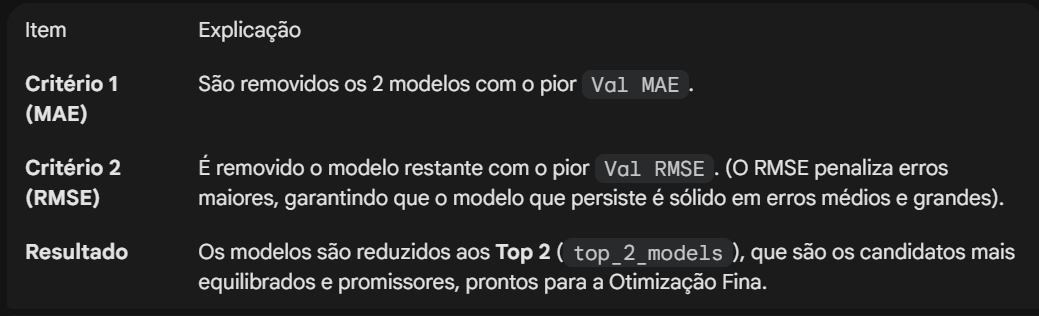

In [36]:
df_selection = results_df.copy()

# 0. Severe Overfitting Filter (Ratio >= 0.5)
initial_count = len(df_selection)
df_selection['Ratio_Phase1'] = df_selection['Train MAE'] / df_selection['Val MAE']
df_selection = df_selection[df_selection['Ratio_Phase1'] >= 0.5]

if len(df_selection) < initial_count:
    discarded = results_df[~results_df.index.isin(df_selection.index)]['Model'].tolist()
    print(f"\nStep 0: Discarded {initial_count - len(df_selection)} models due to severe Overfitting (Ratio < 0.5): {discarded}")

#      Making we have 2 models to proceed
# 1. Discard by MAE: it only discards 2 if there are at least 5 models
if len(df_selection) > 4:
    df_selection = df_selection.sort_values('Val MAE', ascending=True).head(len(df_selection) - 2)
    print(f"Step 1: Discarded 2 models (worst MAE). Remaining: {df_selection['Model'].tolist()}")
elif len(df_selection) == 4: # If there are exactly 4, just discard 1
    df_selection = df_selection.sort_values('Val MAE', ascending=True).head(3)
    print(f"Step 1: Discarded 1 model (worst MAE). Remaining: {df_selection['Model'].tolist()}")

# 2. Discard by RMSE: it only discards 1 if there are more than 2 models
if len(df_selection) > 2:
    df_selection = df_selection.sort_values('Val RMSE', ascending=True).head(len(df_selection) - 1)
    print(f"Step 2: Discarded 1 model (worst RMSE). Remaining: {df_selection['Model'].tolist()}")

# 3. Final Selection by Pinball: if still more than 2
if len(df_selection) > 2:
    df_selection = df_selection.sort_values('Val Pinball (α=0.3)', ascending=True).head(2)
    print(f"Step 3: Selected best 2 by Pinball. Remaining: {df_selection['Model'].tolist()}")
else:
    # Se já só tiveres 2, apenas garante que estão ordenados
    df_selection = df_selection.sort_values('Val Pinball (α=0.3)', ascending=True)

# Top 2 models selected
top_2_models = df_selection['Model'].tolist()
print(f"The {len(top_2_models)} models selected for phase 2 (Refinement/Stacking) are: {top_2_models}")



Step 0: Discarded 1 models due to severe Overfitting (Ratio < 0.5): ['KNeighbors']
Step 1: Discarded 2 models (worst MAE). Remaining: ['GradientBoosting', 'Extra Tree', 'RandomForest']
Step 2: Discarded 1 model (worst RMSE). Remaining: ['GradientBoosting', 'Extra Tree']
The 2 models selected for phase 2 (Refinement/Stacking) are: ['GradientBoosting', 'Extra Tree']


In [37]:
#######################################################################
# 2: more refined optimization focusing on top 2 and anti-overfitting #
#######################################################################
# new grids for the winners of phase 1
models_and_grids_phase2 = {}

if "GradientBoosting" in top_2_models:
    models_and_grids_phase2["GradientBoosting"] = {
        "model": GradientBoostingRegressor(random_state=37, loss='absolute_error'),
        "params": {
            # Refinamento em torno dos 0.05 e depth 8 da Fase 1
            'learning_rate': [0.03, 0.05, 0.07], 
            'max_depth': [7, 8, 9],
            'n_estimators': [500, 800, 1000],
            'subsample': [0.8, 0.85, 0.9],
            'min_samples_leaf': [25, 30, 35]
        }
    }

if "Extra Tree" in top_2_models:
    models_and_grids_phase2["Extra Tree"] = {
        "model": ExtraTreesRegressor(random_state=37, n_jobs=-1, bootstrap=False),
        "params": {
            # Refinamento em torno de 500 estimators e depth 20
            'n_estimators': [500, 600, 700],
            'max_depth': [18, 20, 22, 25],
            'min_samples_leaf': [10, 15, 20],
            'max_features': [0.7, 0.8, 0.9]
        }
    }

# --- STEP 2.2: LOOP DE OTIMIZAÇÃO (MANTIDO E PROTEGIDO) ---
results_list_phase2 = []
print("\nPHASE 2: More Fine-Tuning & Exploration (Top Models: GB & Extra Trees)")
print("="*80)

for model_name, config in models_and_grids_phase2.items():
    print(f"\n---> Refinement: {model_name}")
    
    X_tr = X_train_scaled[selected_features]
    X_vl = X_val_scaled[selected_features]

    # Initialize with the Phase 1 best model
    best_params_f1 = best_params_phase1[model_name]
    model_f1 = clone(config['model']).set_params(**best_params_f1)
    model_f1.fit(X_tr, y_train_log_for_fit)
    
    # Scores for comparison
    best_scores_p2 = evaluate_model(model_f1, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval)
    best_val_mae_p2 = best_scores_p2['Val MAE']
    curr_best_rmse = best_scores_p2['Val RMSE']
    curr_best_pinball = best_scores_p2['Val Pinball (α=0.3)']
    
    best_result_phase2 = {
        'Model': model_name,
        'Best Params': str(best_params_f1),
        'MAE_Ratio': best_scores_p2['Train MAE'] / best_scores_p2['Val MAE'],
        'Source': 'Phase 1 Winner',
        **best_scores_p2,
    }
    
    print(f"  Base (Phase 1): {best_params_f1} | MAE: {best_val_mae_p2:,.2f}")

    # Try 10 new random parameter combinations
    param_combinations = list(product(*config['params'].values()))
    param_keys = list(config['params'].keys())
    tested_params = random.sample(param_combinations, min(len(param_combinations), 10))
    
    for values in tested_params:
        params = dict(zip(param_keys, values))
        if params == best_params_f1: continue
            
        model = clone(config['model']).set_params(**params)
        model.fit(X_tr, y_train_log_for_fit)
        scores = evaluate_model(model, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval)
        
        ovf_ratio = scores['Train MAE'] / scores['Val MAE']
        
        # I. Anti-Overfitting Filter (Ratio > 0.75)
        if ovf_ratio < 0.75:
            print(f"   [REJECTED - OVF] Ratio: {ovf_ratio:.2f} | Params: {params}")
            continue
            
        # II. Stability check (RMSE < 5% degradation, Pinball < 10%)
        rmse_limit = curr_best_rmse * 1.05
        pinball_limit = curr_best_pinball * 1.10
        
        if scores['Val RMSE'] > rmse_limit or scores['Val Pinball (α=0.3)'] > pinball_limit:
            print(f"   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {params}")
            continue

        # III. Update if MAE is better
        if scores['Val MAE'] < best_val_mae_p2:
            best_val_mae_p2 = scores['Val MAE']
            curr_best_rmse = scores['Val RMSE']
            curr_best_pinball = scores['Val Pinball (α=0.3)']
            
            best_result_phase2 = {
                'Model': model_name,
                'Best Params': str(params),
                'MAE_Ratio': ovf_ratio,
                'Source': 'Phase 2 Improvement',
                **scores,
            }
            # new: Print detalhado solicitado
            print(f" New Improvement Found for {model_name}:")
            print(f" Train MAE: {scores['Train MAE']:,.2f} | Val MAE: {scores['Val MAE']:,.2f}")
            print(f" Train Pinball: {scores['Train Pinball (α=0.3)']:,.2f} | Val Pinball: {scores['Val Pinball (α=0.3)']:,.2f}")
            print(f" Train RMSE: {scores['Train RMSE']:,.2f} | Val RMSE: {scores['Val RMSE']:,.2f}")
            print(f" Overfitting Ratio: {ovf_ratio:.2f}\n")

    results_list_phase2.append(best_result_phase2)

# Final Results Visualization
results_df_phase2 = pd.DataFrame(results_list_phase2).sort_values('Val MAE')
display(results_df_phase2[['Model','Train MAE', 'Val MAE','MAE_Ratio','Train Pinball (α=0.3)', 'Val Pinball (α=0.3)','Train RMSE', 'Val RMSE', 'Best Params']])



PHASE 2: More Fine-Tuning & Exploration (Top Models: GB & Extra Trees)

---> Refinement: GradientBoosting


  Base (Phase 1): {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.85, 'max_features': 0.8, 'min_samples_leaf': 30} | MAE: 1,309.13
 New Improvement Found for GradientBoosting:
 Train MAE: 1,078.53 | Val MAE: 1,270.62
 Train Pinball: 511.01 | Val Pinball: 602.68
 Train RMSE: 2,051.82 | Val RMSE: 2,231.86
 Overfitting Ratio: 0.85

   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 800, 'subsample': 0.9, 'min_samples_leaf': 30}
   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8, 'min_samples_leaf': 35}
   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8, 'min_samples_leaf': 30}
   [REJECTED - STABILITY] MAE might be better, but RMSE/Pin

,Model,Train MAE,Val MAE,MAE_Ratio,Train Pinball (α=0.3),Val Pinball (α=0.3),Train RMSE,Val RMSE,Best Params
0,GradientBoosting,1078.532941,1270.620871,0.848824,511.014940,602.682437,2051.823565,2231.864640,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est..."
1,Extra Tree,1310.773196,1430.519413,0.916292,611.592695,670.735605,2416.000602,2542.727737,"{'n_estimators': 500, 'max_depth': 22, 'min_sa..."


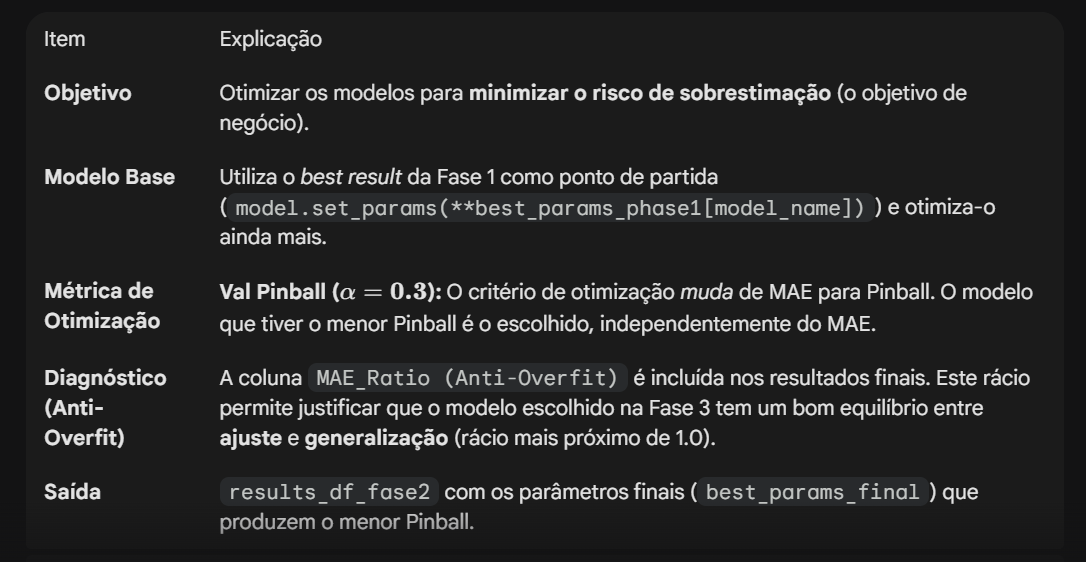

1. O que está a acontecer e quais os modelos?Sim, o Stacking está a ser aplicado aos dois melhores modelos que sobreviveram à Fase 2 (que, no teu caso, foram o GradientBoosting e o ExtraTrees).O fluxo foi:Fase 1: Benchmarking rápido de 5 famílias de modelos $\rightarrow$ Seleção dos Top 2/3 mais "honestos" e precisos.Fase 2: Fine-tuning desses Top 2, procurando o melhor MAE sob restrições de Pinball e Overfitting $\rightarrow$ Obtenção dos best_params_final.Fase 3 (Stacking): Pega nesses dois "especialistas" afinados e coloca um "juiz" (o Ridge) por cima deles para aprender a combinar as suas forças.2. Para que serve cada parâmetro e o mistério do CV?estimators: É a tua lista de modelos base (GB e ET). Eles funcionam em paralelo. Cada um faz a sua previsão.final_estimator=Ridge(alpha=10.0): É o Meta-Modelo. Em vez de fazermos apenas uma média aritmética simples (50/50), o Ridge aprende pesos: $Previsão = w_1 \times GB + w_2 \times ET$. O alpha=10.0 garante que este juiz é conservador e não dá peso excessivo a apenas um modelo.cv=5: Este é o ponto crucial. Não gera Data Leakage.O problema: Se treinássemos os modelos base no Train e pedíssemos para eles preverem o próprio Train, as previsões seriam "perfeitas demais". O Meta-modelo (Ridge) acharia que os modelos base nunca erram e não aprenderia a corrigir as falhas deles.A solução (Out-of-fold): O Stacking divide internamente o dataset em 5 partes (folds). Ele treina em 4 e prevê na 5ª (que o modelo não viu). Ele repete isto até ter uma previsão "independente" para cada linha do dataset. O Ridge é treinado nestas previsões "honestas".

APAGAR


Re-treino dos Estimadores Base: O StackingRegressor pega em cada modelo da tua lista final_estimators (o teu Gradient Boosting e o teu Extra Trees afinados) e executa o .fit() neles usando todos os dados de X_train_full_scaled. Portanto, eles agora "vêem" e aprendem com as observações que antes estavam apenas no set de validação.

Geração de Previsões "Honestas" (Cross-Validation): Para que o Meta-Modelo (Ridge) não seja enganado, o Stacking usa o esquema de cv=5. Ele divide o Full Dataset em 5, treina em 4 partes e prevê na 5ª. Ele faz isto para criar uma coluna de previsões para o Gradient Boosting e outra para o Extra Trees.

Treino do Meta-Modelo (O Juiz): O Ridge(alpha=10.0) é então treinado usando essas previsões como "features" e o y_train_full_log como alvo. Ele aprende: "Quando o GB diz X e o ET diz Y, o preço real costuma ser Z".

Fit Final de Persistência: Após treinar o Ridge, o Stacking faz um último fit de todos os estimadores base no dataset completo de uma vez só, para garantir que, quando fores prever o X_test, os modelos base estão no seu pico de conhecimento.

In [38]:
# ---------------------------------------------------------------------------------------
# FASE 3: STACKING ENSEMBLE FINAL
# ---------------------------------------------------------------------------------------

# 1. Preparar os estimadores base com os parâmetros da FASE 2
final_estimators = []
for result in results_list_phase2:
    name = result['Model']
    # eval converte a string de parâmetros de volta para dicionário
    params = eval(result['Best Params']) 
    
    # Criar a instância do modelo
    model_instance = clone(models_and_grids[name]['model'])
    
    # Aplicar os parâmetros da Fase 1 (base) + Fase 2 (refinamento)
    if name in best_params_phase1:
        model_instance.set_params(**best_params_phase1[name])
    model_instance.set_params(**params)
    
    final_estimators.append((name.lower().replace(" ", "_"), model_instance))

# 2. Criar o Stacking Regressor
# O Ridge(alpha=10) é o "juiz" que decide quanto peso dar a cada modelo
stacking_model = StackingRegressor(
    estimators=final_estimators,
    final_estimator=Ridge(alpha=10.0), 
    cv=5, 
    n_jobs=-1
)

# 3. Treinar no Full Dataset
print(f"\nTraining Final Stacking Ensemble with: {[e[0] for e in final_estimators]}")
stacking_model.fit(X_train_full_scaled[selected_features], y_train_full_log)

# 4. Avaliação Final (sempre no conjunto de validação para o relatório)
y_val_final_pred = np.expm1(stacking_model.predict(X_val_scaled[selected_features]))
final_mae = mean_absolute_error(y_val_array, y_val_final_pred)

print(f"- FINAL STACKING VAL MAE: {final_mae:,.2f} £")
#PRINT FINAL STACKING TRAIN MAE
y_train_final_pred = np.expm1(stacking_model.predict(X_train_full_scaled[selected_features]))
final_train_mae = mean_absolute_error(y_train_full_array, y_train_final_pred)
print(f"- FINAL STACKING TRAIN MAE: {final_train_mae:,.2f} £")


Training Final Stacking Ensemble with: ['gradientboosting', 'extra_tree']
- FINAL STACKING VAL MAE: 1,094.77 £
- FINAL STACKING TRAIN MAE: 1,094.94 £


In [39]:
# Concatenate the feature sets and the log-transformed targets for the full training
X_train_full_scaled = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_log    = np.concatenate([y_train_log, y_val_log])

# using only the features from feature selection
X_full_final = X_train_full_scaled[selected_features]
y_full_log_final = y_train_full_log

# retrain the stacking model on the full dataset
stacking_model.fit(X_full_final, y_full_log_final)

# Ensure we use exactly the same columns for test data as in training
X_test_final = X_test_scaled[selected_features]

# Make predictions (price is still in log scale)
test_preds_log = stacking_model.predict(X_test_final)

# Inverse transformation from log scale to original price scale
test_predictions_final = np.expm1(test_preds_log)

# Export submission file
print("Creating the submission file...")
submission_df = pd.DataFrame({
    'carID': X_test_final.index,
    'price': test_predictions_final
})

# Export to CSV
filename = "./project_data/Group37_Version31.csv"
submission_df.to_csv(filename, index=False)

print("\nFirst 5 rows of the final file:")
display(submission_df.head())

Creating the submission file...

First 5 rows of the final file:


,carID,price
0,89856,12869.658787
1,106581,21769.196117
2,80886,13401.306163
3,100174,17039.223436
4,81376,22777.819078


In [40]:
artifacts_model = {
    'model': stacking_model,
    'features_in_model': selected_features 
}
joblib.dump(artifacts_model, './project_data/final_regression_model.sav.gz', compress=3)

['./project_data/final_regression_model.sav.gz']

In [42]:
from IPython.display import display, HTML

# configurate LIME explainer: we use the full training data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_full_scaled[selected_features].values,
    feature_names=selected_features,
    mode='regression',
    verbose=True,
    random_state=37
)

#Choose a specific row from the test set to explain
row_idx = 0 
observation = X_test_scaled[selected_features].iloc[row_idx]

def predict_fn_with_names(x_array):
    #converts the numpy array back to DataFrame with original names
    x_df = pd.DataFrame(x_array, columns=selected_features)
    #predict original price from log predictions
    return np.expm1(stacking_model.predict(x_df))

print(f"Generating explanation for the car (carID): {X_test_scaled.index[row_idx]}...")
exp = explainer.explain_instance(
    data_row=observation.values, 
    predict_fn=predict_fn_with_names,
    num_features=10
)

display(HTML(exp.as_html()))

price_predicted = predict_fn_with_names(observation.values.reshape(1, -1))[0]
print(f"\nPredicted Price by Stacking: £{price_predicted:,.2f}")

print("\nTop 5 Features Influencing this prediction:")
for feature, weight in exp.as_list()[:5]:
    direction = "Increases price" if weight > 0 else "Decreases price"
    print(f" -> {feature:30} | Weight: {weight:8.2f} | {direction}")

Generating explanation for the car (carID): 89856...
Intercept 14927.059810085311
Prediction_local [17716.21315133]
Right: 12869.658787494243



Predicted Price by Stacking: £12,869.66

Top 5 Features Influencing this prediction:
 -> age_squared <= 1.00            | Weight:  3056.82 | Increases price
 -> transmission_manual <= 0.00    | Weight:  1818.58 | Increases price
 -> -0.78 < model_mean_price <= 0.06 | Weight: -1588.84 | Decreases price
 -> fuelType_hybrid <= 0.00        | Weight:  -988.03 | Decreases price
 -> mpg_per_liter <= -0.56         | Weight:   952.12 | Increases price


"Utilizámos o LIME para uma explicação local, o que significa que não estamos a ver o que é importante para todos os carros, mas sim o que foi determinante para este carro específico. Isto é vital para a transparência do modelo, permitindo entender se o Stacking está a tomar decisões baseadas em lógica económica (ex: penalizar carros mais velhos) ou em ruído."